In [12]:
from itertools import combinations
import matplotlib.pyplot as plt

import pandas as pd

import scripts.preprocessing as pp
import seaborn as sns
from sklearn.metrics import f1_score
import statsmodels.api as sm

sns.set_theme( palette="pastel") 

# Import des données. 

On s'attache à observer la récession `USRECD` notre variable cible telle que:

$$
\left\{
\begin{array}{c}
Y=1 \text{ en cas de récession} \\
Y=0 \text{ sinon}
\end{array}
\right.
$$


In [2]:
dft=pp.dft

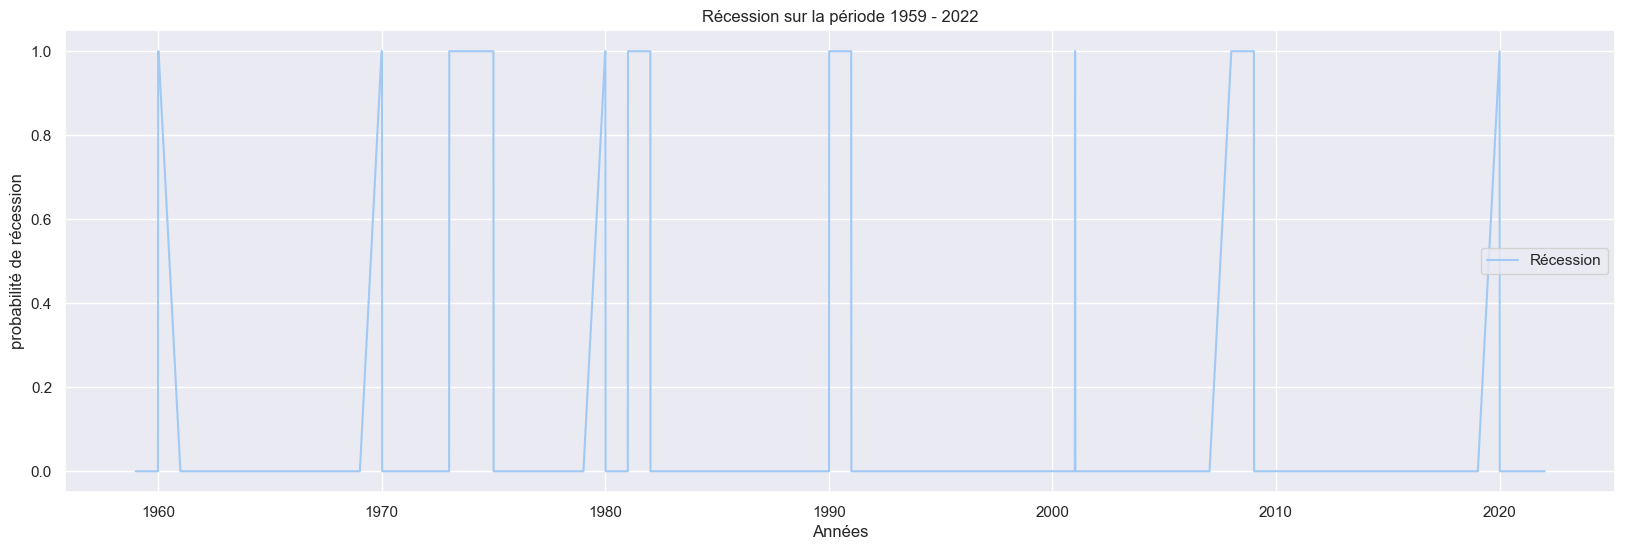

In [3]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=dft,x='DATE',y='USRECD', label='Récession')
plt.xlabel('Années')
plt.ylabel('probabilité de récession')
plt.title('Récession sur la période 1959 - 2022')
plt.legend()
plt.show()

# Recherche du Lag optimal en fonction du Pseudo $R^2$ d'Estrella

In [5]:
Xpropre,Ypropre=dft.drop(columns=["USRECD","DATE"]), dft["USRECD"]
max_lags = 10
lags_optimal = []

#estimer le meilleur lag au sens du pseudo R2
for variable in Xpropre.columns:
    optimal_lag = 0
    X=sm.add_constant(Xpropre[variable]) #initialiser le modèle de base (lag= 0)
    model = sm.Probit(Ypropre, X).fit()
    estrella_max = model.prsquared**((-2/len(Xpropre))*model.llf)     
    
    # Parcourir différents lags
    for lag in range(1, max_lags+1):
        
        X_temp= X.shift(lag)

        temp_df=pd.concat([Ypropre,X_temp], axis=1)
        temp_df.dropna(subset=temp_df.columns, how='any', inplace=True)
        temp_df.reset_index(drop=True, inplace=True)

        X_temp= temp_df.drop(columns=["USRECD"])
        y_temp= temp_df["USRECD"]

        model = sm.Probit(y_temp, X_temp).fit()
        estrella = model.prsquared**((-2/len(X_temp))*model.llf)  

        if ( estrella > estrella_max ):
            optimal_lag = lag
            estrella_max = estrella
     
    # Ajouter le lag optimal 
    lags_optimal.append(optimal_lag)
# Stocker nos lags optimaux pour chaque variable
lags_optimal = dict(zip(Xpropre.columns, lags_optimal))

# Créer les variables laggées en fonction des lags optimaux
for col in Xpropre.columns:
    if lags_optimal[col]!=0:
        dft[f"{col} lag {lags_optimal[col]}"]= dft[col].shift(lags_optimal[col])
    
dft.dropna(subset=dft.columns, how='any', inplace=True)
dft.reset_index(drop=True, inplace=True)

Xpropre,Ypropre=dft.drop(columns=["USRECD","DATE"]), dft["USRECD"]

# Classer nos variables par R2
classement=[]
student=[]
for col in Xpropre.columns : # parcourt chaque colonne 
    X = sm.add_constant(Xpropre[col]) # ajoute constante au modele
    model = sm.Probit(Ypropre, X).fit()
    
    estrella = model.prsquared**((-2/len(Xpropre))*model.llf) 
    t= model.pvalues[1]<0.01 #t-stat inférieur à 1%
    classement= classement + [{"name":col,"r2": estrella,"t-stat à 1%":t}] 
classement.sort(key=lambda x: x.get('r2'),reverse=True) #trie en fonction du r2


Optimization terminated successfully.
         Current function value: 0.307359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354222
  

C:\Users\yoanj\AppData\Local\Temp\ipykernel_70248\2570613516.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dft[f"{col} lag {lags_optimal[col]}"]= dft[col].shift(lags_optimal[col])
C:\Users\yoanj\AppData\Local\Temp\ipykernel_70248\2570613516.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dft[f"{col} lag {lags_optimal[col]}"]= dft[col].shift(lags_optimal[col])
C:\Users\yoanj\AppData\Local\Temp\ipykernel_70248\2570613516.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Optimization terminated successfully.
         Current function value: 0.298393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.286730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.209348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.253967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.260632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250117
  

In [6]:
classement

[{'name': 'FPIx', 'r2': 0.6890997823879247, 't-stat à 1%': True},
 {'name': 'T5YFFM lag 3', 'r2': 0.6334710368787198, 't-stat à 1%': True},
 {'name': 'CPF3MTB3Mx lag 1', 'r2': 0.6174285519370694, 't-stat à 1%': True},
 {'name': 'CMRMTSPLx', 'r2': 0.5990876036626419, 't-stat à 1%': True},
 {'name': 'PRFIx lag 1', 'r2': 0.5819036808428061, 't-stat à 1%': True},
 {'name': 'CPF3MTB3Mx', 'r2': 0.5687504936271384, 't-stat à 1%': True},
 {'name': 'UMCSENTx', 'r2': 0.5687313685094527, 't-stat à 1%': True},
 {'name': 'TB3SMFFM lag 1', 'r2': 0.5636668579172383, 't-stat à 1%': True},
 {'name': 'USCONS', 'r2': 0.5574724749576363, 't-stat à 1%': True},
 {'name': 'PRFIx', 'r2': 0.5440923163914387, 't-stat à 1%': True},
 {'name': 'AAAFFM lag 3', 'r2': 0.5438518507886483, 't-stat à 1%': True},
 {'name': 'Y033RC1Q027SBEAx', 'r2': 0.5289139683165126, 't-stat à 1%': True},
 {'name': 'IPDMAT', 'r2': 0.5177887394802132, 't-stat à 1%': True},
 {'name': 'PNFIx', 'r2': 0.502036767186981, 't-stat à 1%': True},

# Split

In [10]:
split =pd.to_datetime('01/03/1995') # date du split

train_df = dft[dft['DATE'] < split]
test_df = dft[dft['DATE'] >= split]

X_train, y_train = train_df.drop(columns=['DATE','USRECD']),train_df["USRECD"]
X_test,y_test=test_df.drop(columns=['DATE','USRECD']),test_df["USRECD"]

# Sélection de variable en utilisant métrique F1

Parmi 20 variables on retire les variables redondantes et inutiles au sens économique/financier

In [8]:
# récupérer 10 variables parmi 20
variables_30=[variable['name'] for variable in classement[:20]if variable['name'] not in ["CPF3MTB3Mx lag 1","PRFIx lag 1","CPF3MTB3Mx",
                                                                                             "UMCSENTx","TB3SMFFM lag 1","PRFIx","AAAFFM lag 3",
                                                                                             "IPDMAT","PNFIx","DMANEMP"]]

In [13]:
# Stocker la meilleur combinaison au sens du F1
meilleure_combinaison_F1= []
meilleur_F1 = 0

combinaisons_possibles = []

for i in range(1,len(variables_30)+1) : 

    # test toutes les combinaisons possibles
    combinaisons_i = combinations(variables_30, i)
    
    # rajoute les combi possibles
    combinaisons_possibles.extend(combinaisons_i)

for i in range(len(combinaisons_possibles)) : 

    X_train_F1=sm.add_constant(X_train[list(combinaisons_possibles[i])]) # ajoute la constante que par rapport au modèle testé
    probit_model_F1=sm.Probit(y_train,X_train_F1)
    result_F1=probit_model_F1.fit()

    X_test_F1=sm.add_constant(X_test[list(combinaisons_possibles[i])])
    pred_F1 = result_F1.predict(X_test_F1)

    f1 = f1_score(y_test, pred_F1.apply(lambda x: 1 if x>0.5 else 0))

    if f1 > meilleur_F1 :
        meilleur_F1 = f1
        meilleure_combinaison_F1 = probit_model_F1.exog_names

print(f"La meilleure combinaison possible est : {meilleure_combinaison_F1} pour un F1 Score de {meilleur_F1}.")

Optimization terminated successfully.
         Current function value: 0.208811
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311940
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.253209
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.243145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299562
  

In [14]:
print(f"La meilleure combinaison possible est : {meilleure_combinaison_F1} pour un F1 Score de {meilleur_F1}.")

La meilleure combinaison possible est : ['const', 'FPIx', 'CMRMTSPLx', 'GS10TB3Mx lag 4', 'IPMANSICS'] pour un F1 Score de 0.9.
